In [1]:
# Import necessary libraries
import os
import sys
import joblib
import numpy as np
import pandas as pd
from joblib import dump
import subprocess as sp
import dask.array as da
from pprint import pprint
import matplotlib.pyplot as plt
from odc.io.cgroups import get_cpu_quota
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
training_data = "L_training_data(1).txt"

# Define candidate classifiers
models = {
    "RandomForest": RandomForestClassifier,
    "GradientBoosting": GradientBoostingClassifier
}

# Define the metric
metric = 'balanced_accuracy'

In [3]:
# Set cross-validation splits
inner_cv_splits = 5
outer_cv_splits = 5
test_size = 0.20

In [4]:
# Get the number of CPUs available
ncpus = round(get_cpu_quota())
print('ncpus = ' + str(ncpus))

ncpus = 4


In [5]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

#convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

In [6]:
# Parameter grids for GridSearchCV
param_grids = {
    "RandomForest": {
        'class_weight': ['balanced'],
        'n_estimators': [250],
        'criterion': ['gini', 'entropy'],
        'max_depth': [10],
        'max_features': ['sqrt', 'log2']
    },
    "GradientBoosting": {
        'n_estimators': [100, 250],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}

In [7]:
# Define the outer cross-validation
outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True, random_state=0)

# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []

results_summary = {}

for model_name, Classifier in models.items():
    print(f"\n===== Evaluating {model_name} =====")
    param_grid = param_grids[model_name]
    
    acc, f1, roc_auc = [], [], []
    i = 1
    
    for train_index, test_index in outer_cv.split(X, y):
        print(f"Working on {i}/{outer_cv_splits} outer cv split", end='\r')
        model = Classifier(random_state=1)
        
        X_tr, X_tt = X[train_index, :], X[test_index, :]
        y_tr, y_tt = y[train_index], y[test_index]
        
        inner_cv = KFold(n_splits=inner_cv_splits, shuffle=True, random_state=0)
        
        clf = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=metric,
            n_jobs=ncpus,
            refit=True,
            cv=inner_cv,
        )
        clf.fit(X_tr, y_tr)
        best_model = clf.best_estimator_
        pred = best_model.predict(X_tt)
        
        # Metrics
        probs = best_model.predict_proba(X_tt)
        y_tt_bin = label_binarize(y_tt, classes=np.unique(y))
        for j in range(len(np.unique(y))):
            fpr, tpr, _ = roc_curve(y_tt_bin[:, j], probs[:, j])
            roc_auc.append(auc(fpr, tpr))
        
        acc.append(balanced_accuracy_score(y_tt, pred))
        f1.append(f1_score(y_tt, pred, average='weighted'))
        i += 1
    
    results_summary[model_name] = {
        "Mean ROC AUC": np.mean(roc_auc),
        "Mean Accuracy": np.mean(acc),
        "Mean F1": np.mean(f1)
    }
    
    print(f"\n{model_name} Results:")
    print(f"Mean ROC AUC: {np.mean(roc_auc):.4f}")
    print(f"Mean Accuracy: {np.mean(acc):.4f}")
    print(f"Mean F1 Score: {np.mean(f1):.4f}")
    
    # Train final model on full dataset
    rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=0)
    clf = GridSearchCV(Classifier(), param_grid, scoring=metric, verbose=1, cv=rs.split(X, y), n_jobs=ncpus)
    clf.fit(X, y)
    
    best_params = clf.best_params_
    final_model = Classifier(**best_params, random_state=1, n_jobs=ncpus if 'n_jobs' in Classifier().get_params() else None)
    final_model.fit(X, y)
    
    model_filename = f"L_model_{model_name.lower()}.joblib"
    dump(final_model, model_filename)
    print(f"Saved best {model_name} model to {model_filename}")



===== Evaluating RandomForest =====
Working on 5/5 outer cv split
RandomForest Results:
Mean ROC AUC: 0.9571
Mean Accuracy: 0.8199
Mean F1 Score: 0.8198
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Saved best RandomForest model to L_model_randomforest.joblib

===== Evaluating GradientBoosting =====
Working on 5/5 outer cv split
GradientBoosting Results:
Mean ROC AUC: 0.9559
Mean Accuracy: 0.8125
Mean F1 Score: 0.8129
Fitting 5 folds for each of 8 candidates, totalling 40 fits


TypeError: GradientBoostingClassifier.__init__() got an unexpected keyword argument 'n_jobs'

In [8]:
print("=== Nested K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: " + str(round(np.mean(acc), 2)))
print("Std balanced accuracy: " + str(round(np.std(acc), 2)))
print('\n')
print("Mean F1: " + str(round(np.mean(f1), 2)))
print("Std F1: " + str(round(np.std(f1), 2)))
print('\n')
print("Mean roc_auc: " + str(round(np.mean(roc_auc), 3)))
print("Std roc_auc: " + str(round(np.std(roc_auc), 2)))
print('=============================================')

=== Nested K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.81
Std balanced accuracy: 0.02


Mean F1: 0.81
Std F1: 0.02


Mean roc_auc: 0.956
Std roc_auc: 0.03


In [9]:
print('\n')
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The " + metric + " score using these parameters is: ")
print(round(clf.best_score_, 2))



The most accurate combination of tested parameters is: 
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}


The balanced_accuracy score using these parameters is: 
0.83


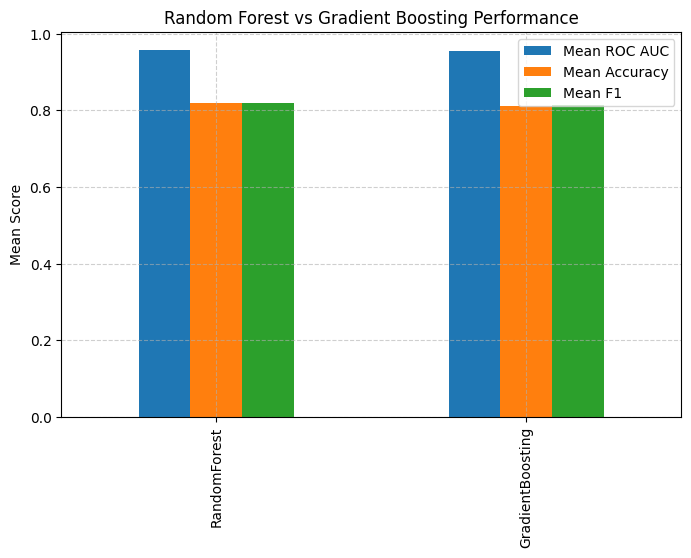

In [10]:
pd.DataFrame(results_summary).T.plot(kind='bar', figsize=(8,5))
plt.title('Random Forest vs Gradient Boosting Performance')
plt.ylabel('Mean Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()